In [172]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import EM
import helper 
import pickle

from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from helper import plot_cluster, plot_cluster_3d

np.random.seed(1904)

reload(EM) # Used to reload the module in case changes were made outside of this notebook
reload(helper)

<module 'helper' from '/home/dang/Documents/COGS118b/fitbit/fitbitEM/helper.py'>

In [14]:
df = pd.read_csv('data', index_col=0, parse_dates=True)

In [15]:
df.head()

,MinutesAsleep,StartTime,Steps,Heartrate
2018-01-01,393.0,2018-01-01T01:20:30.000,10841,71.0
2018-01-02,525.0,2018-01-01T23:26:00.000,12531,69.0
2018-01-03,530.0,2018-01-02T23:15:30.000,11281,67.0
2018-01-04,360.0,2018-01-04T01:17:00.000,25315,65.0
2018-01-05,554.0,2018-01-04T23:44:00.000,11483,64.0


In [16]:
data = df[features].dropna().values # We only care about plotting points with complete data. 

In [51]:
def plot_features(data, features, ax, elv, azm, alpha=None, colors=None):
    ax.scatter(data[:,0], data[:,1], data[:,2], alpha=alpha, color = colors)
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel(features[2])
    ax.view_init(elv, azm)

## Unclustered Data

Let's revisit the raw data to get a sense of what it looks like before we perform clustering. 

In [10]:
colors   = ['blue', 'green', 'red'] # We'll use the same ordering of colors for all graphs to stay consistent. 
features = ['MinutesAsleep', 'Steps', 'Heartrate'] # Likewise we maintain the order of the features. 

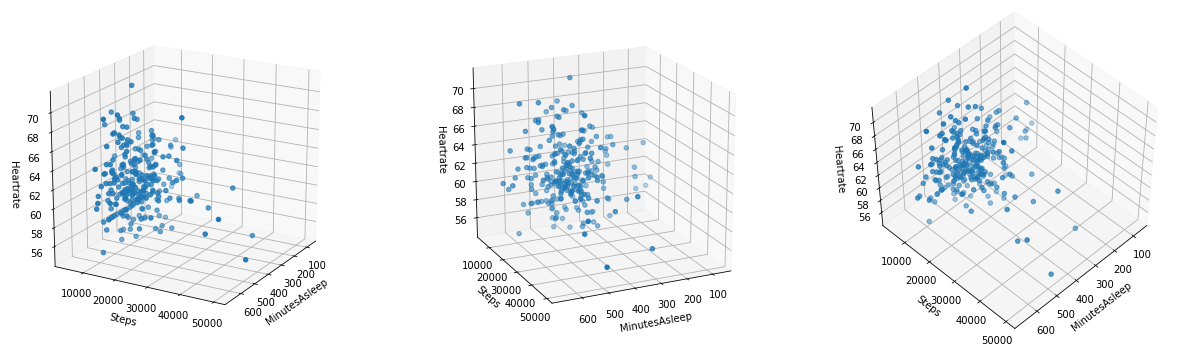

In [20]:
elevations = [20, 20, 50]
azimuths = [30, 65, 45]

fig = plt.figure(figsize=(21,6))
for i, (elv, azm) in enumerate(zip(elevations, azimuths)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_features(data, features, ax, elv, azm)

## Naive Clustering

First we perform EM directly on the data by selecting random points as the initial means and then iterate until convergence. We will then compare this to the smarter approach of finding the means of each cluster before running EM and then using those values during initialization. 

### E-Step

In [146]:
em = EM.EM(data, 3)
(mu, sigma, pi) = em.initialize_params()

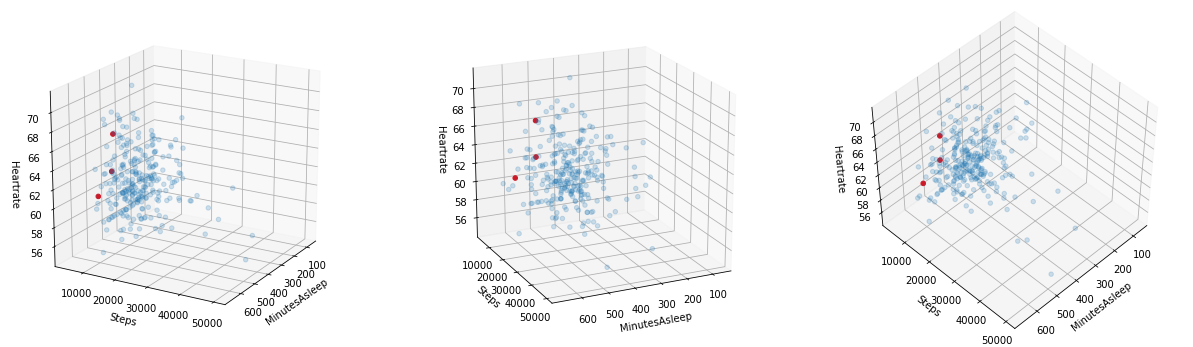

In [147]:
K = mu.shape[0]
fig = plt.figure(figsize=(21,6))
for i, (elv, azm) in enumerate(zip(elevations, azimuths)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_features(data, features, ax, elv, azm, alpha=.2)
    ax.scatter(mu[:,0],mu[:,1],mu[:,2], color='red', alpha=1)

Given these random points as cluster centers we can perform the E step in EM and determine the responsibilities that each center has for the rest of the data points. Graphing those responsibilities will show us the initial clusters. 

In [148]:
gamma_z = np.nan_to_num(em.E_step(mu, sigma, pi))

In [149]:
def get_cluster_colors(data, gamma_z):
    colors = []
    for x in range(len(data)):
        colors.append((gamma_z[0, x], gamma_z[1, x], gamma_z[2, x]))
        
    return colors

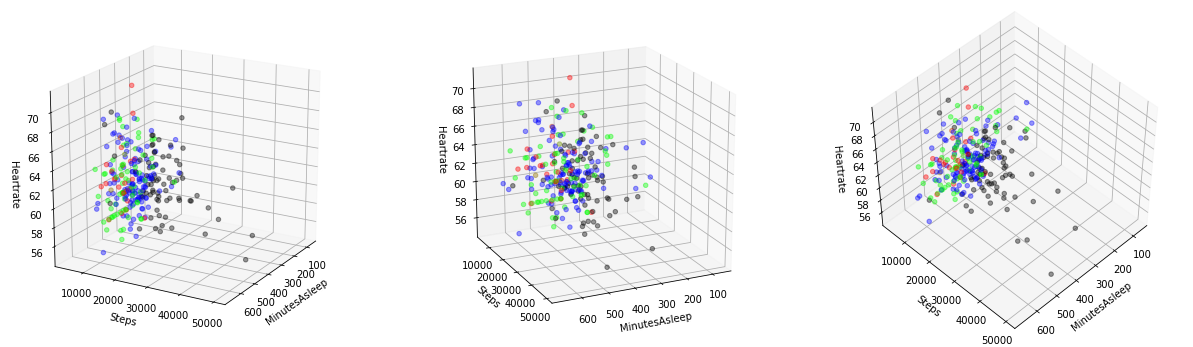

In [150]:
fig = plt.figure(figsize=(21,6))
for i, (elv, azm) in enumerate(zip(elevations, azimuths)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_features(data, features, ax, elv, azm, alpha=.4, colors=get_cluster_colors(data, gamma_z))

As expected the clustering is abysmal. In fact, there's certain points that don't even have an assigned cluster, which technically shouldn't happen but does because of how numpy returns NaNs for really low probabilities. 

### M-step

Now we'll perform a couple iterations of EM to see how the clusters form with each iteration. 

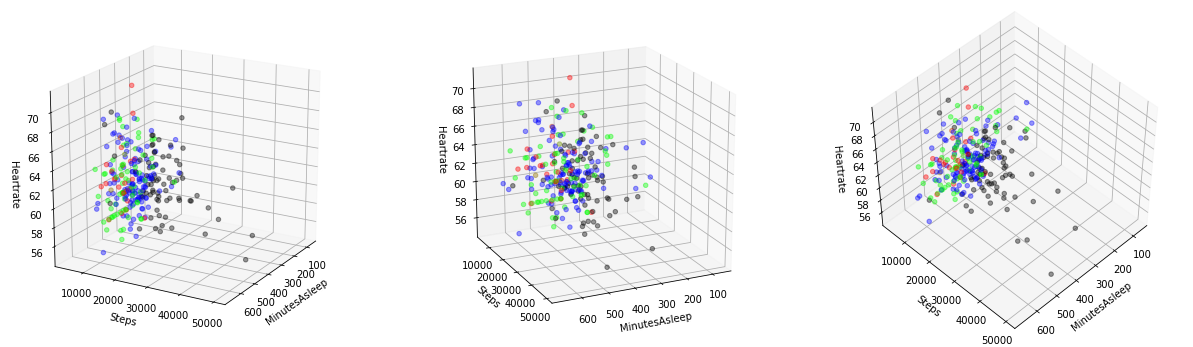

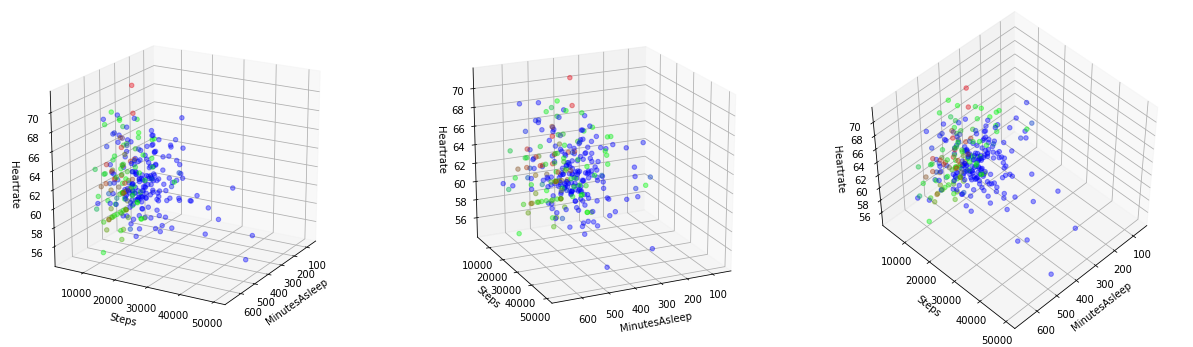

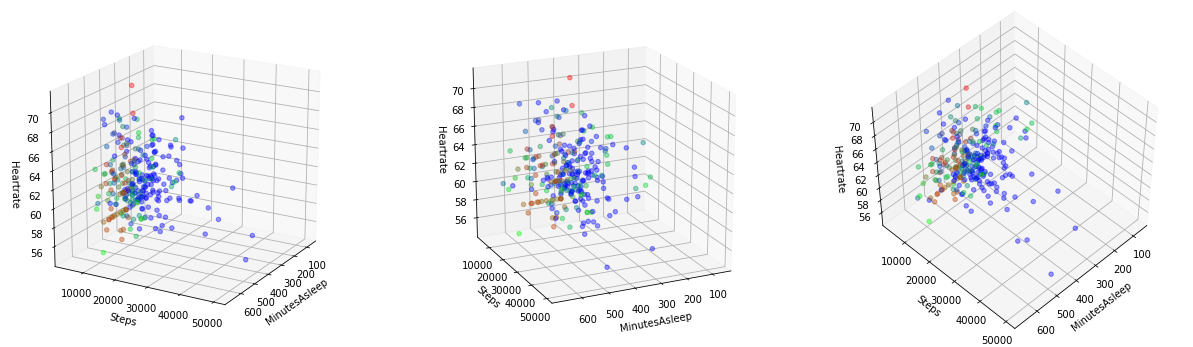

In [151]:
prev_likelihood = em.eval_log_likelihood(mu, sigma, pi)
for epoch in range(3):
    gamma_z = np.nan_to_num(em.E_step(mu, sigma, pi))
    fig = plt.figure(figsize=(21,6))
    for i, (elv, azm) in enumerate(zip(elevations, azimuths)):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        plot_features(data, features, ax, elv, azm, alpha=.4, colors=get_cluster_colors(data, gamma_z))
    
    
    (mu, sigma, pi) = em.M_step(mu, sigma, gamma_z)
    log_likelihood = em.eval_log_likelihood(mu, sigma, pi)
    
    if(abs(log_likelihood - prev_likelihood < 0.00001)):
        break
    prev_likelihood = log_likelihood

This looks better but we haven't let EM iterate until convergence, so we'll do that now and see what the end result looks like. 

In [152]:
for epoch in range(10000):
    gamma_z = np.nan_to_num(em.E_step(mu, sigma, pi))
    (mu, sigma, pi) = em.M_step(mu, sigma, gamma_z)
    log_likelihood = em.eval_log_likelihood(mu, sigma, pi)
    
    if(abs(log_likelihood - prev_likelihood < 0.000001)):
        break
    prev_likelihood = log_likelihood

In [153]:
log_likelihood

-19.96778910119197

Looks like EM converged to a log likelihood of about -20, which is a somewhat arbitrary number for now, but we'll compare it later to the log likelihood of performing EM with better initial means to get a sense of the difference in performing. This will serve as a quantative assessment to go along with the qualitative assessments we make about the images. 

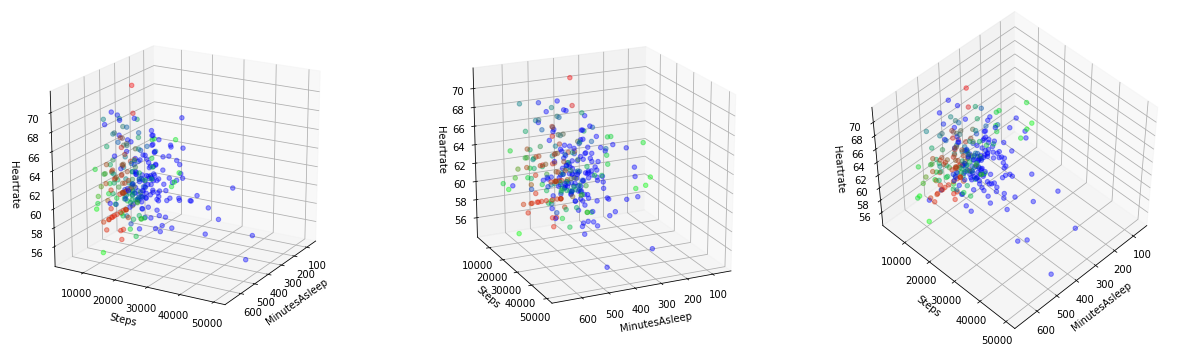

In [168]:
fig = plt.figure(figsize=(21,6))
for i, (elv, azm) in enumerate(zip(elevations, azimuths)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_features(data, features, ax, elv, azm, alpha=.4, colors=get_cluster_colors(data, gamma_z))

If we compare this to the ground truth clustering from earlier, we see the results are not quite optimal. 

<img src="groundtruth_clusters.png" alt="Drawing" style="width: 125%; max-width:none; margin-left: -150px; align: center"/>

**Some obersevations**:
    * The marathon cluster seem to be captured pretty well in the EM generated image, most likely because of how extreme the observations are on the steps axis. 
    * The Summer and Fall Quarter clusters do not seem to make it through

### Clustering with pre-initialized centers

Now that we've seen how EM performs with random cluster centers, lets try a smarter approach by finding the actual centers of each cluster before hand and using those as the initialization values for EM and see if the clustering does any better.  

In [180]:
end_of_marathon_idx = df.dropna().index.get_loc('2018-06-04')
end_of_summer_idx = df.dropna().index.get_loc('2018-09-26')

In [228]:
marathon_mu = np.mean(data[:end_of_marathon_idx], axis = 0)
marathon_sigma = np.sqrt(np.var(data[:end_of_marathon_idx], axis = 0)) * np.eye(3)

summer_mu = np.mean(data[end_of_marathon_idx:end_of_summer_idx], axis = 0)
summer_sigma = np.sqrt(np.var(data[end_of_marathon_idx:end_of_summer_idx], axis = 0)) * np.eye(3)

fall_mu = np.mean(data[end_of_summer_idx:], axis = 0)
fall_sigma = np.sqrt(np.var(data[end_of_summer_idx:], axis = 0)) * np.eye(3)

mu = np.vstack((marathon_mu, summer_mu, fall_mu))
sigma = np.stack((marathon_sigma, summer_sigma, fall_sigma), axis = 0)
pi = em.initialize_pi()

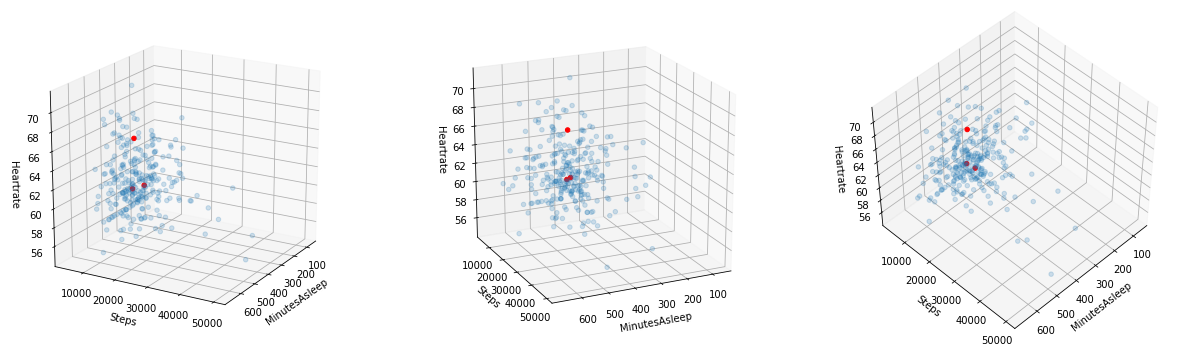

In [229]:
fig = plt.figure(figsize=(21,6))
for i, (elv, azm) in enumerate(zip(elevations, azimuths)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_features(data, features, ax, elv, azm, alpha=.2)
    ax.scatter(mu[:,0],mu[:,1],mu[:,2], color='red', alpha=1)

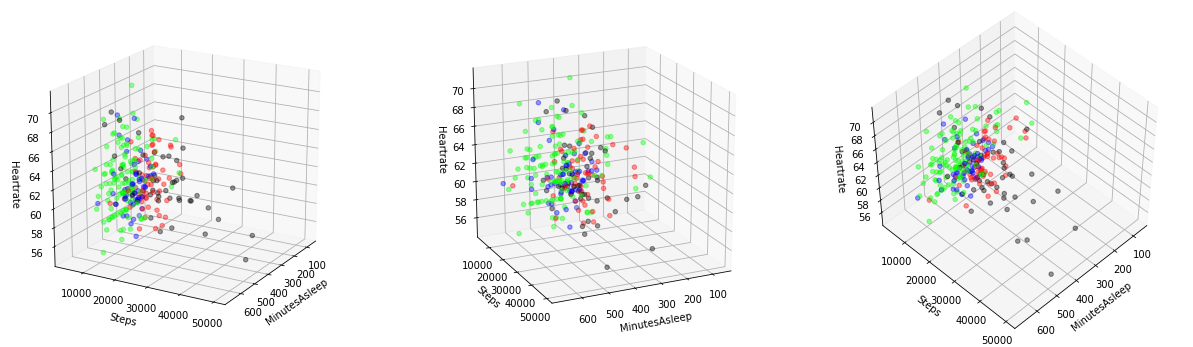

In [232]:
gamma_z = np.nan_to_num(em.E_step(mu, sigma, pi))
fig = plt.figure(figsize=(21,6))
for i, (elv, azm) in enumerate(zip(elevations, azimuths)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_features(data, features, ax, elv, azm, alpha=.4, colors=get_cluster_colors(data, gamma_z))

In [253]:
for epoch in range(10000):
    gamma_z = np.nan_to_num(em.E_step(mu, sigma, pi))
    (mu, sigma, pi) = em.M_step(mu, sigma, gamma_z)
    log_likelihood = em.eval_log_likelihood(mu, sigma, pi)
    
    if(abs(log_likelihood - prev_likelihood < 0.000001)):
        break
    prev_likelihood = log_likelihood

In [254]:
log_likelihood

-20.718979408963047

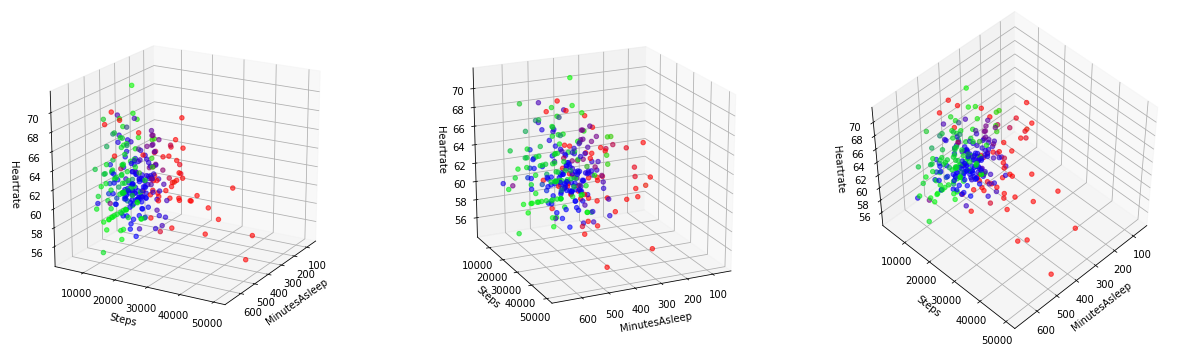

In [256]:
gamma_z = np.nan_to_num(em.E_step(mu, sigma, pi))
fig = plt.figure(figsize=(21,6))
for i, (elv, azm) in enumerate(zip(elevations, azimuths)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_features(data, features, ax, elv, azm, alpha=.6, colors=get_cluster_colors(data, gamma_z))